### 目的

借助tweets进行关于苹果公司的情感分析。

### 因变量

单条tweet的情感评分。由课程小组发布在Amazon Mechanical Turk上。评分取[-2,2]，五人打分取平均值。

### 自变量

**Bag of Words**：单词出现的个数。

In [2]:
tweets = read.csv("./data//tweets.csv", stringsAsFactors=FALSE)
str(tweets)

'data.frame':	1181 obs. of  2 variables:
 $ Tweet: chr  "I have to say, Apple has by far the best customer care service I have ever received! @Apple @AppStore" "iOS 7 is so fricking smooth & beautiful!! #ThanxApple @Apple" "LOVE U @APPLE" "Thank you @apple, loving my new iPhone 5S!!!!!  #apple #iphone5S pic.twitter.com/XmHJCU4pcb" ...
 $ Avg  : num  2 2 1.8 1.8 1.8 1.8 1.8 1.6 1.6 1.6 ...


In [3]:
tweets$Negative = as.factor(tweets$Avg <= -1)
table(tweets$Negative)


FALSE  TRUE 
  999   182 

安装text mining包`tm`。

In [4]:
install.packages("tm", repos = "http://cran.us.r-project.org")

also installing the dependencies 'NLP', 'slam'



package 'NLP' successfully unpacked and MD5 sums checked
package 'slam' successfully unpacked and MD5 sums checked
package 'tm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CYS\AppData\Local\Temp\Rtmpk5edOd\downloaded_packages


In [5]:
library(tm)

Loading required package: NLP


In [6]:
install.packages("SnowballC", repos = "http://cran.us.r-project.org")

package 'SnowballC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\CYS\AppData\Local\Temp\Rtmpk5edOd\downloaded_packages


In [7]:
library(SnowballC)

创建语料库，并进行预处理。

In [20]:
corpus = Corpus(VectorSource(tweets$Tweet))
corpus

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 1181

要以`content_transformer(tolower)`取代`tolower`。参考文献：[DocumentTermMatrix error on Corpus argument](http://stackoverflow.com/questions/24191728/documenttermmatrix-error-on-corpus-argument)

In [21]:
corpus = tm_map(corpus, content_transformer(tolower))
corpus = tm_map(corpus, removePunctuation)

In [22]:
stopwords("english")[1:10]

[1] "i"         "me"        "my"        "myself"    "we"        "our"      
 [7] "ours"      "ourselves" "you"       "your"

In [23]:
corpus = tm_map(corpus, removeWords, c("apple", stopwords("english")))

In [24]:
corpus = tm_map(corpus, stemDocument)

Bag of Words。矩阵的每一行代表一条tweet，每一列代表一个词，矩阵中的值是词频。

In [26]:
frequencies = DocumentTermMatrix(corpus)
frequencies

<<DocumentTermMatrix (documents: 1181, terms: 3289)>>
Non-/sparse entries: 8980/3875329
Sparsity           : 100%
Maximal term length: 115
Weighting          : term frequency (tf)

观察矩阵的局部，非常稀疏。

In [28]:
inspect(frequencies[1000:1005, 505:514])

<<DocumentTermMatrix (documents: 6, terms: 10)>>
Non-/sparse entries: 1/59
Sparsity           : 98%
Maximal term length: 9
Weighting          : term frequency (tf)

      Terms
Docs   cheapen cheaper check cheep cheer cheerio cherylcol chief chiiiiqu child
  1000       0       0     0     0     0       0         0     0        0     0
  1001       0       0     0     0     0       0         0     0        0     0
  1002       0       0     0     0     0       0         0     0        0     0
  1003       0       0     0     0     0       0         0     0        0     0
  1004       0       0     0     0     0       0         0     0        0     0
  1005       0       0     0     0     1       0         0     0        0     0


至少出现20次的单词。

In [29]:
findFreqTerms(frequencies, lowfreq=20)

[1] "android"              "anyon"                "app"                 
 [4] "appl"                 "back"                 "batteri"             
 [7] "better"               "buy"                  "can"                 
[10] "cant"                 "come"                 "dont"                
[13] "fingerprint"          "freak"                "get"                 
[16] "googl"                "ios7"                 "ipad"                
[19] "iphon"                "iphone5"              "iphone5c"            
[22] "ipod"                 "ipodplayerpromo"      "itun"                
[25] "just"                 "like"                 "lol"                 
[28] "look"                 "love"                 "make"                
[31] "market"               "microsoft"            "need"                
[34] "new"                  "now"                  "one"                 
[37] "phone"                "pleas"                "promo"               
[40] "promoipodplayerpromo" "realli"               "releas"              
[43] "samsung"              "say"                  "store"               
[46] "thank"                "think"                "time"                
[49] "twitter"              "updat"                "use"                 
[52] "via"                  "want"                 "well"                
[55] "will"                 "work"

只保留在超过0.5%的tweet中出现过的单词。只剩下309个单词。

In [31]:
sparse = removeSparseTerms(frequencies, 0.995)
sparse

<<DocumentTermMatrix (documents: 1181, terms: 309)>>
Non-/sparse entries: 4669/360260
Sparsity           : 99%
Maximal term length: 20
Weighting          : term frequency (tf)

转换成一个dataframe，同时令列名的首元素不为数字。

In [32]:
tweetsSparse = as.data.frame(as.matrix(sparse))
colnames(tweetsSparse) = make.names(colnames(tweetsSparse))
tweetsSparse$Negative = tweets$Negative

In [33]:
library(caTools)
set.seed(123)
split = sample.split(tweetsSparse$Negative, SplitRatio=0.7)
train = subset(tweetsSparse, split==TRUE)
test = subset(tweetsSparse, split==FALSE)

分类树

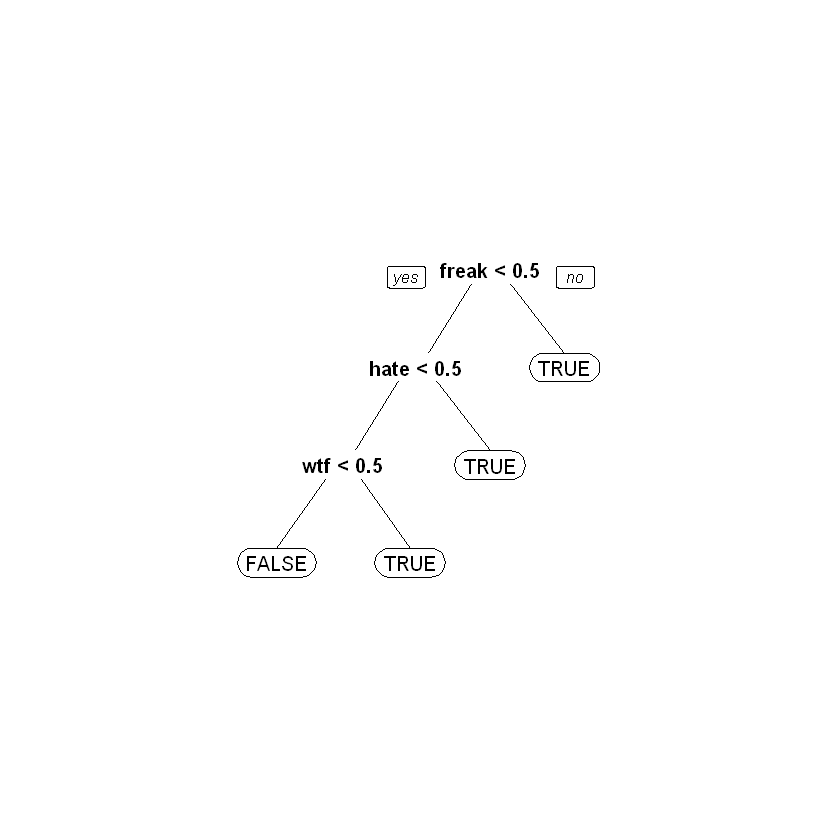

In [35]:
library(rpart)
library(rpart.plot)
tweetCART = rpart(Negative ~ ., data=train, method="class")
prp(tweetCART)

In [36]:
predictCART = predict(tweetCART, newdata=test, type="class")
table(test$Negative, predictCART)

       predictCART
        FALSE TRUE
  FALSE   294    6
  TRUE     37   18

In [37]:
(294+18)/(294+6+37+18)

[1] 0.8788732

基准模型：总预测为非消极。

In [38]:
table(test$Negative)


FALSE  TRUE 
  300    55 

In [39]:
300/355

[1] 0.8450704

随机森林

In [40]:
library(randomForest)
set.seed(123)
tweetRF = randomForest(Negative ~ ., data=train)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [41]:
predictRF = predict(tweetRF, newdata=test)
table(test$Negative, predictRF)

       predictRF
        FALSE TRUE
  FALSE   293    7
  TRUE     34   21

In [42]:
(293+21)/(293+7+34+21)

[1] 0.884507

逻辑斯蒂

In [44]:
tweetLog = glm(Negative ~ ., data=train, family=binomial)
predictLog = predict(tweetLog, newdata=test, type="response")
table(test$Negative, predictLog > 0.5)

Warning message:
: glm.fit: algorithm did not convergeWarning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurredWarning message:
In predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == : prediction from a rank-deficient fit may be misleading

       
        FALSE TRUE
  FALSE   253   47
  TRUE     22   33

In [45]:
(253+33)/(253+47+22+33)

[1] 0.8056338